# TFT MONITORING SYSTEM

## Temporal Fusion Transformer for Server Monitoring

### 🚀 STREAMLINED TFT WORKFLOW:
1. `setup()` - Initialize TFT environment
2. `generate_dataset()` - Generate realistic server metrics
3. `train()` - Train TFT model with PyTorch Forecasting
4. `test()` - Test multi-horizon predictions
5. `demo()` - Run live monitoring demo

### 🎯 TFT FEATURES:
- **Multi-horizon forecasting**: Predict 6 steps ahead (30 minutes)
- **Attention mechanism**: Identify important features automatically
- **Uncertainty quantification**: Get confidence intervals with predictions
- **GPU acceleration**: Optimized for CUDA with mixed precision
- **Secure storage**: Models saved with Safetensors format

### 📊 MONITORING:
- `status()` - Check system status
- `cleanup()` - Clean old files

**Architecture:** PyTorch 2.0.1 + PyTorch Lightning 2.0.2 + PyTorch Forecasting

**Model:** TemporalFusionTransformer with attention-based feature importance

#### Generate dataset
python metrics_generator.py --hours 168 --output training/metrics_dataset.json

#### Train model
python tft_model_trainer.py --epochs 30 --batch-size 32

#### Run inference
python tft_inference.py --input-file test_data.json --output-file predictions.json

In [1]:
# Import the clean TFT monitoring system
from main import setup, generate_dataset, train, predict, status
from config import CONFIG
import warnings
warnings.filterwarnings('ignore')

print("🎯 TFT Monitoring System - Production Version")
print("=" * 50)
print("✅ Modules loaded successfully")
print(f"📊 Default time span: {CONFIG['time_span_hours']} hours")
print(f"🖥️  Servers: {CONFIG['servers_count']}")
print(f"🎯 Prediction horizon: {CONFIG['prediction_horizon']} steps (30 min)")

🎯 TFT Monitoring System - Production Version
✅ Modules loaded successfully
📊 Default time span: 720 hours
🖥️  Servers: 15
🎯 Prediction horizon: 96 steps (30 min)


In [2]:
# 1. Setup and validate environment
print("STEP 1: Environment Setup")
print("-" * 30)

if setup():
    print("\n✅ Environment ready for TFT training!")
    print("\nNext: Generate dataset with your desired hours")
else:
    print("\n❌ Setup failed - check dependencies")

STEP 1: Environment Setup
------------------------------
🔍 Validating environment...
✅ PyTorch: 2.0.1+cu118
✅ Lightning: 2.0.2
✅ PyTorch Forecasting: Available
✅ Safetensors: Available
🔥 GPU: NVIDIA GeForce RTX 4090

✅ Environment ready for TFT training!

Next: Generate dataset with your desired hours


In [3]:
# 2. Check current system status
print("STEP 2: System Status")
print("-" * 30)

status()

STEP 2: System Status
------------------------------
🔍 System Status
✅ Dataset: Available
   Records: 2,880
   Servers: 10
   Hours: 24
   Total samples: 2880
✅ Models: Available
   Latest: tft_model_20250807_191510
   Format: Safetensors ✅
✅ GPU: NVIDIA GeForce RTX 4090


## 📊 Dataset Generation

- Pass hours directly to override config default
- Generates realistic server patterns
- Includes temporal variations (idle, spike, heavy load)

In [4]:
# 3. Generate dataset - NOW PROPERLY USES HOURS PARAMETER!
print("STEP 3: Dataset Generation")
print("-" * 30)

# Generate 2 weeks of data (336 hours)
HOURS = 24  # Change this to any value you want

print(f"\n🚀 Generating {HOURS} hours of server metrics...")
print(f"📊 This will create ~{HOURS * 12 * CONFIG['servers_count']:,} samples")

success = generate_dataset(hours=HOURS)

if success:
    print("\n✅ Dataset generation complete!")
else:
    print("\n❌ Generation failed")

STEP 3: Dataset Generation
------------------------------

🚀 Generating 24 hours of server metrics...
📊 This will create ~4,320 samples
🚀 Generating 24 hours of time series data...
📊 This will create ~2,880 samples
✅ Generated 2,880 records
💾 Saved to: training\metrics_dataset.json
📋 Dataset structure:
   Records: 2880
   Servers: 10
   Time span: 24 hours
   Sample keys: ['id', 'timestamp', 'server_id', 'status', 'timeframe', 'severity', 'explanation', 'cpu_percent', 'memory_percent', 'disk_percent', 'load_average']

✅ Dataset generation complete!


In [5]:
# Optional: Verify the dataset was created with correct hours
import json
from pathlib import Path

dataset_path = Path(CONFIG['training_dir']) / 'metrics_dataset.json'
if dataset_path.exists():
    with open(dataset_path, 'r') as f:
        data = json.load(f)
    
    metadata = data['metadata']
    print("📊 Dataset Verification:")
    print(f"   Total samples: {metadata['total_samples']:,}")
    print(f"   Time span: {metadata['time_span_hours']} hours ✅")
    print(f"   Servers: {metadata['servers_count']}")
    print(f"   Anomaly ratio: {metadata['anomaly_ratio']:.1%}")
    print(f"   Poll interval: {metadata['poll_interval_seconds']}s")

📊 Dataset Verification:
   Total samples: 2,880
   Time span: 24 hours ✅
   Servers: 10
   Anomaly ratio: 15.0%
   Poll interval: 300s


## 🏋️ Model Training

Train the Temporal Fusion Transformer:
- Multi-horizon forecasting (6 steps ahead)
- Attention-based feature importance
- Quantile loss for uncertainty estimation
- Automatic GPU acceleration if available

In [6]:
# 4. Train TFT model
print("STEP 4: TFT Model Training")
print("-" * 30)

# Optional: Adjust training parameters
EPOCHS = 10  # Reduce for faster testing

print(f"\n🏋️ Training TFT for {EPOCHS} epochs...")
print("⚡ This will use GPU if available")
print("📊 Features: Multi-horizon prediction, attention mechanism")

success = train(epochs=EPOCHS)

if success:
    print("\n🎉 Training completed successfully!")
else:
    print("\n❌ Training failed - check logs above")

STEP 4: TFT Model Training
------------------------------

🏋️ Training TFT for 10 epochs...
⚡ This will use GPU if available
📊 Features: Multi-horizon prediction, attention mechanism
🏋️ Starting TFT training...
📊 Loading dataset...
✅ Loaded 2,880 records
📊 Available columns: ['id', 'timestamp', 'server_id', 'status', 'timeframe', 'severity', 'explanation', 'cpu_percent', 'memory_percent', 'disk_percent', 'load_average']
📊 Sample record keys: ['id', 'timestamp', 'server_id', 'status', 'timeframe', 'severity', 'explanation', 'cpu_percent', 'memory_percent', 'disk_percent', 'load_average']
📊 Series lengths - Min: 288, Max: 288
📊 Unique servers: 10
📊 Using encoder length: 24, prediction length: 6
📊 Training cutoff: 230


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


✅ Training samples: 2360
✅ Validation samples: 10
📊 Using batch size: 16
📊 Train batches: 147
📊 Val batches: 1
✅ Model created with 21,997 parameters
🚀 Training for 10 epochs...


You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 2     
3  | prescalers                         | ModuleDict                      | 160   
4  | static_variable_selection          | VariableSelectionNetwork        | 1.7 K 
5  | e

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


✅ Training completed successfully!
💾 Safetensors model saved: models\tft_model_20250807_192138\model.safetensors
✅ Model saved to: models\tft_model_20250807_192138

🎉 Training completed successfully!


In [7]:
# Check training results
from pathlib import Path

models_dir = Path(CONFIG['models_dir'])
if models_dir.exists():
    model_dirs = sorted(models_dir.glob('tft_model_*'))
    if model_dirs:
        latest_model = model_dirs[-1]
        print(f"✅ Latest model: {latest_model.name}")
        
        # Check model files
        files = list(latest_model.glob('*'))
        print("\n📦 Model contents:")
        for f in files:
            size_kb = f.stat().st_size / 1024
            print(f"   {f.name}: {size_kb:.1f} KB")

✅ Latest model: tft_model_20250807_192138

📦 Model contents:
   config.json: 0.2 KB
   model.safetensors: 126.2 KB
   training_metadata.json: 0.2 KB


## 🔮 Inference & Predictions

Run predictions on:
- Sample data (automatic generation)
- Your own metrics
- Real-time data streams

In [8]:
# 5. Run predictions with sample data
print("STEP 5: Model Inference")
print("-" * 30)

print("\n🔮 Running predictions on sample data...")

# Make predictions
results = predict()

if results and 'predictions' in results:
    print("\n📈 Predictions (next 30 minutes):")
    for metric, values in results['predictions'].items():
        current = values[0]
        future = values[-1]
        trend = "📈" if future > current else "📉" if future < current else "➡️"
        print(f"   {metric}: {current:.1f} {trend} {future:.1f}")
    
    if results.get('alerts'):
        print(f"\n⚠️  {len(results['alerts'])} alerts generated:")
        for alert in results['alerts'][:3]:
            icon = "🔴" if alert['severity'] == 'critical' else "🟡"
            print(f"   {icon} {alert['metric']}: {alert['value']:.1f} (step {alert['steps_ahead']})")
    else:
        print("\n✅ No alerts - system healthy")

STEP 5: Model Inference
------------------------------

🔮 Running predictions on sample data...
📊 Generating sample data...

📈 Predictions (next 30 minutes):
   cpu_percent: 43.6 📉 40.0
   memory_percent: 57.9 📉 54.8
   disk_percent: 45.6 📈 48.1
   load_average: 1.7 📉 0.0

✅ No alerts - system healthy


In [9]:
# 6. Test with custom metrics data
import numpy as np
from datetime import datetime, timedelta

print("STEP 6: Custom Predictions")
print("-" * 30)

# Create custom metrics showing gradual CPU increase
custom_data = []
base_cpu = 40
for i in range(30):  # 30 time points = 2.5 hours
    custom_data.append({
        'timestamp': (datetime.now() - timedelta(minutes=5*i)).isoformat(),
        'cpu_percent': base_cpu + (i * 1.5) + np.random.normal(0, 3),  # Gradual increase
        'memory_percent': 60 + np.random.normal(0, 5),
        'disk_percent': 45 + np.random.normal(0, 2),
        'load_average': 2.0 + (i * 0.05) + np.random.normal(0, 0.2)
    })

print("\n📊 Testing with trending CPU increase scenario...")
results = predict(custom_data)

if results and 'alerts' in results:
    critical = [a for a in results['alerts'] if a['severity'] == 'critical']
    warnings = [a for a in results['alerts'] if a['severity'] == 'warning']
    
    print(f"\n🚨 Alert Summary:")
    print(f"   Critical: {len(critical)}")
    print(f"   Warnings: {len(warnings)}")
    
    if critical:
        print("\n🔴 Critical Alerts:")
        for alert in critical[:2]:
            print(f"   {alert['metric']} will reach {alert['value']:.1f} in {alert['steps_ahead']*5} minutes")

STEP 6: Custom Predictions
------------------------------

📊 Testing with trending CPU increase scenario...

🚨 Alert Summary:
   Critical: 0
   Warnings: 6


## 📊 Visualization & Analysis

Optional: Visualize predictions and trends

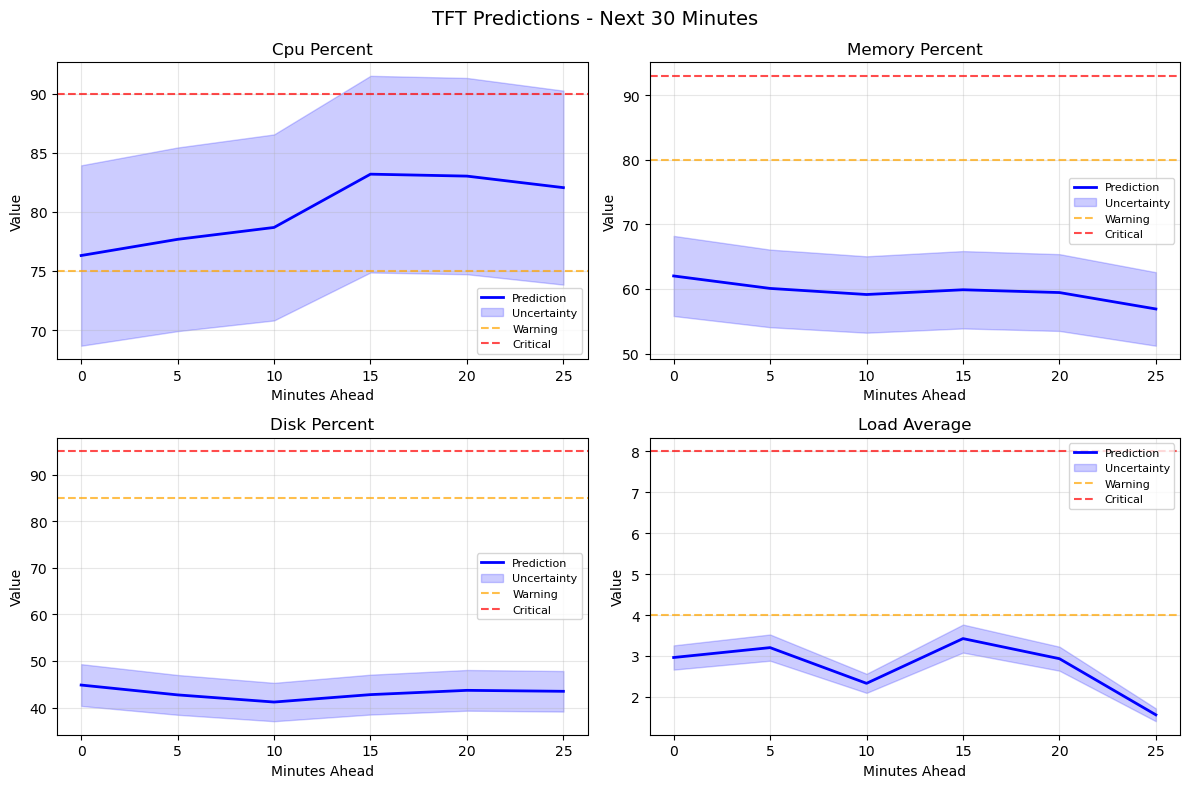

📊 Visualization complete


In [10]:
# 7. Optional: Visualize predictions
try:
    import matplotlib.pyplot as plt
    
    if results and 'predictions' in results:
        fig, axes = plt.subplots(2, 2, figsize=(12, 8))
        fig.suptitle('TFT Predictions - Next 30 Minutes', fontsize=14)
        
        metrics = list(results['predictions'].keys())[:4]
        
        for idx, (ax, metric) in enumerate(zip(axes.flat, metrics)):
            if metric in results['predictions']:
                values = results['predictions'][metric]
                time_points = [i*5 for i in range(len(values))]
                
                ax.plot(time_points, values, 'b-', linewidth=2, label='Prediction')
                ax.fill_between(time_points, 
                               [v*0.9 for v in values], 
                               [v*1.1 for v in values], 
                               alpha=0.2, color='blue', label='Uncertainty')
                
                # Add threshold lines
                if metric in CONFIG['alert_thresholds']:
                    warning = CONFIG['alert_thresholds'][metric]['warning']
                    critical = CONFIG['alert_thresholds'][metric]['critical']
                    ax.axhline(y=warning, color='orange', linestyle='--', alpha=0.7, label='Warning')
                    ax.axhline(y=critical, color='red', linestyle='--', alpha=0.7, label='Critical')
                
                ax.set_title(metric.replace('_', ' ').title())
                ax.set_xlabel('Minutes Ahead')
                ax.set_ylabel('Value')
                ax.grid(True, alpha=0.3)
                ax.legend(loc='best', fontsize=8)
        
        plt.tight_layout()
        plt.show()
        
        print("📊 Visualization complete")
    
except ImportError:
    print("⚠️  Matplotlib not installed - skipping visualization")
    print("   Install with: pip install matplotlib")

📊 Generating sample data...
📊 Generating sample data...
✅ Plots saved to: plots\my_analysis.[png|svg]


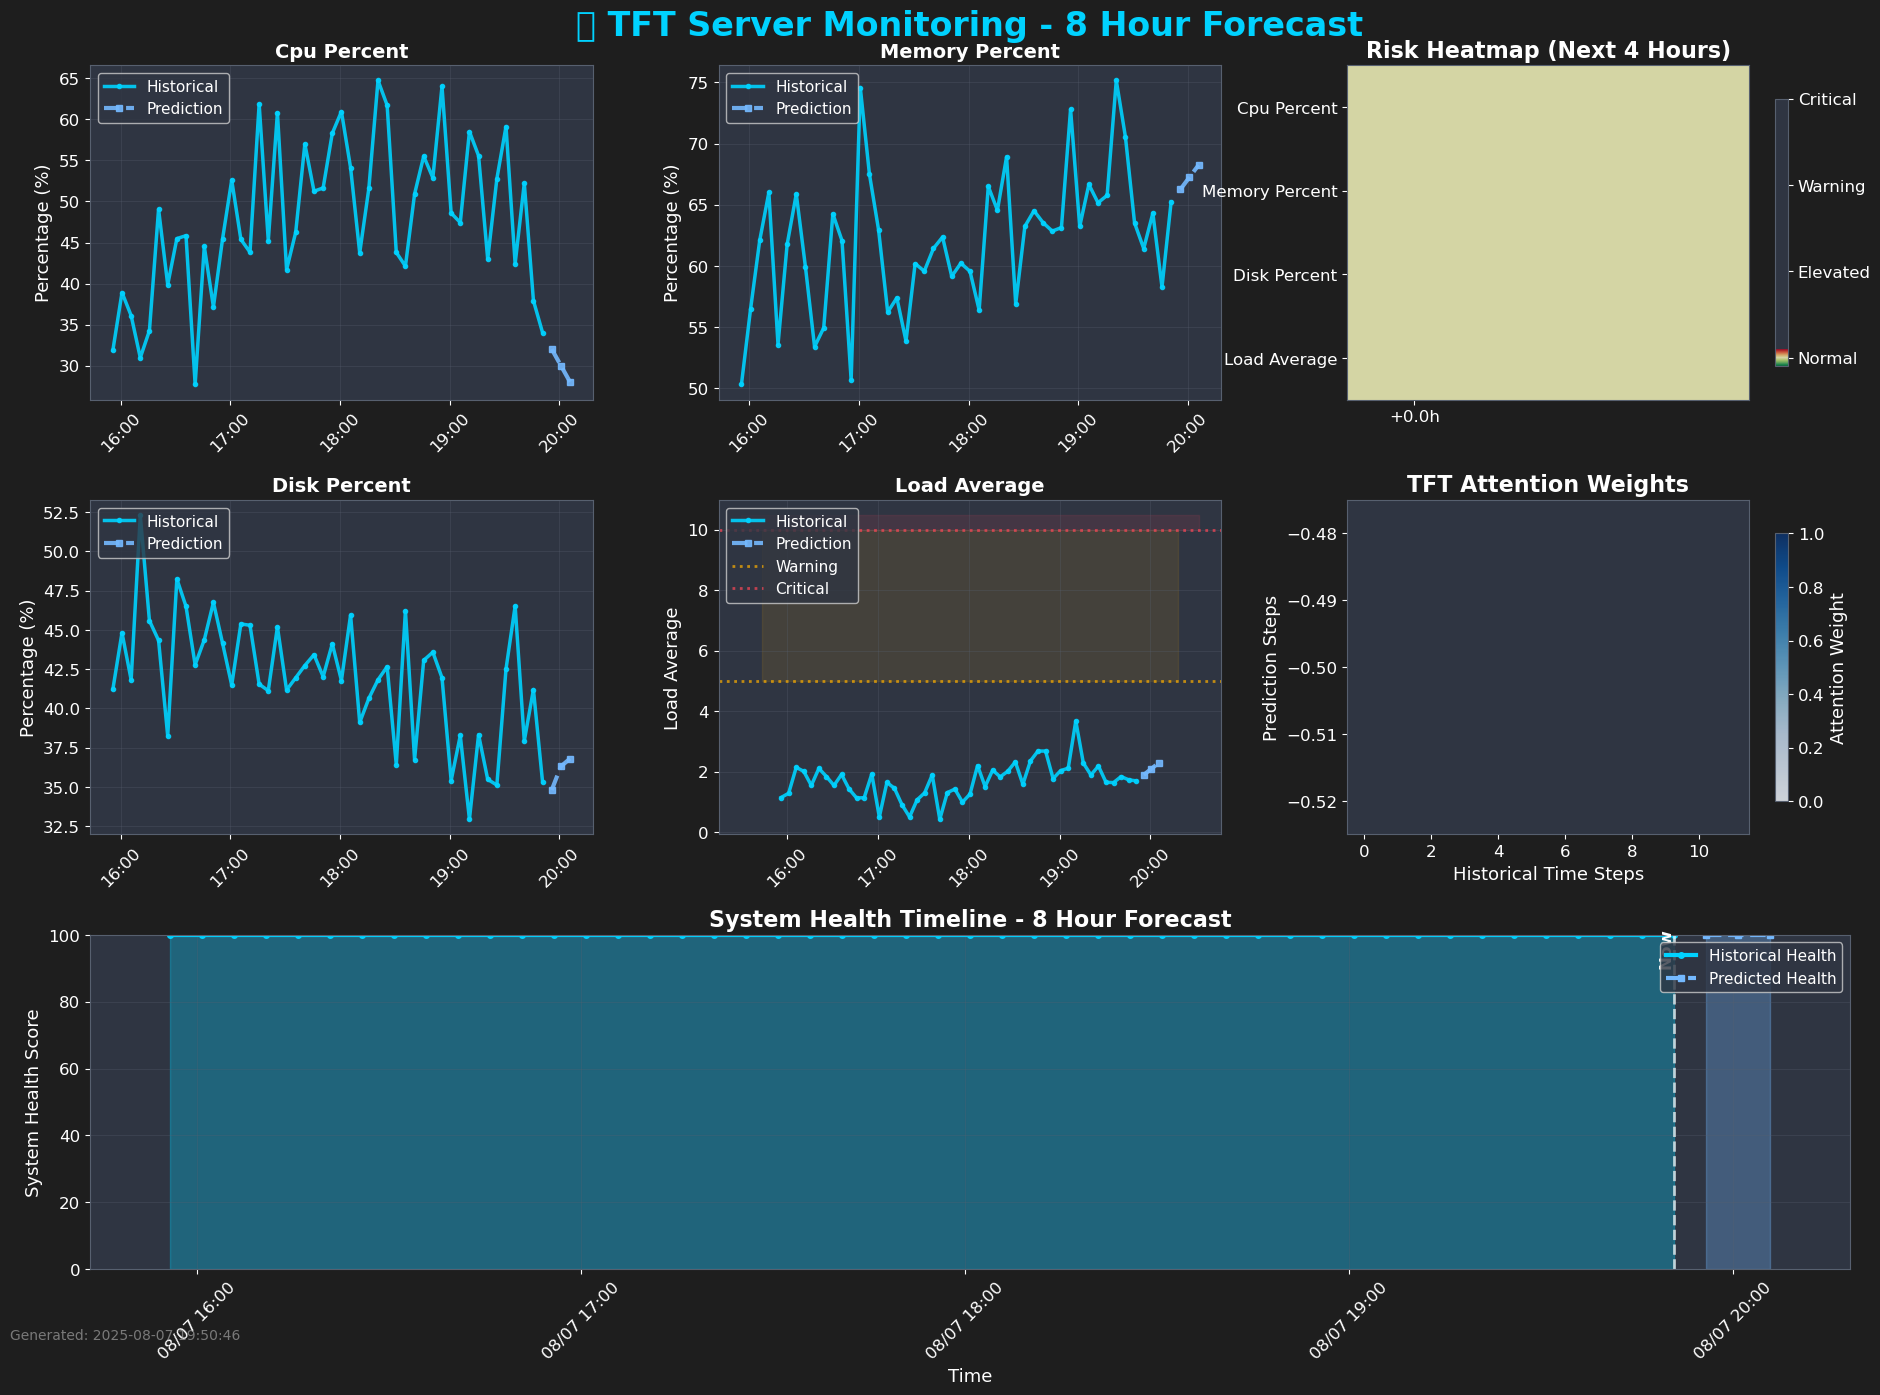

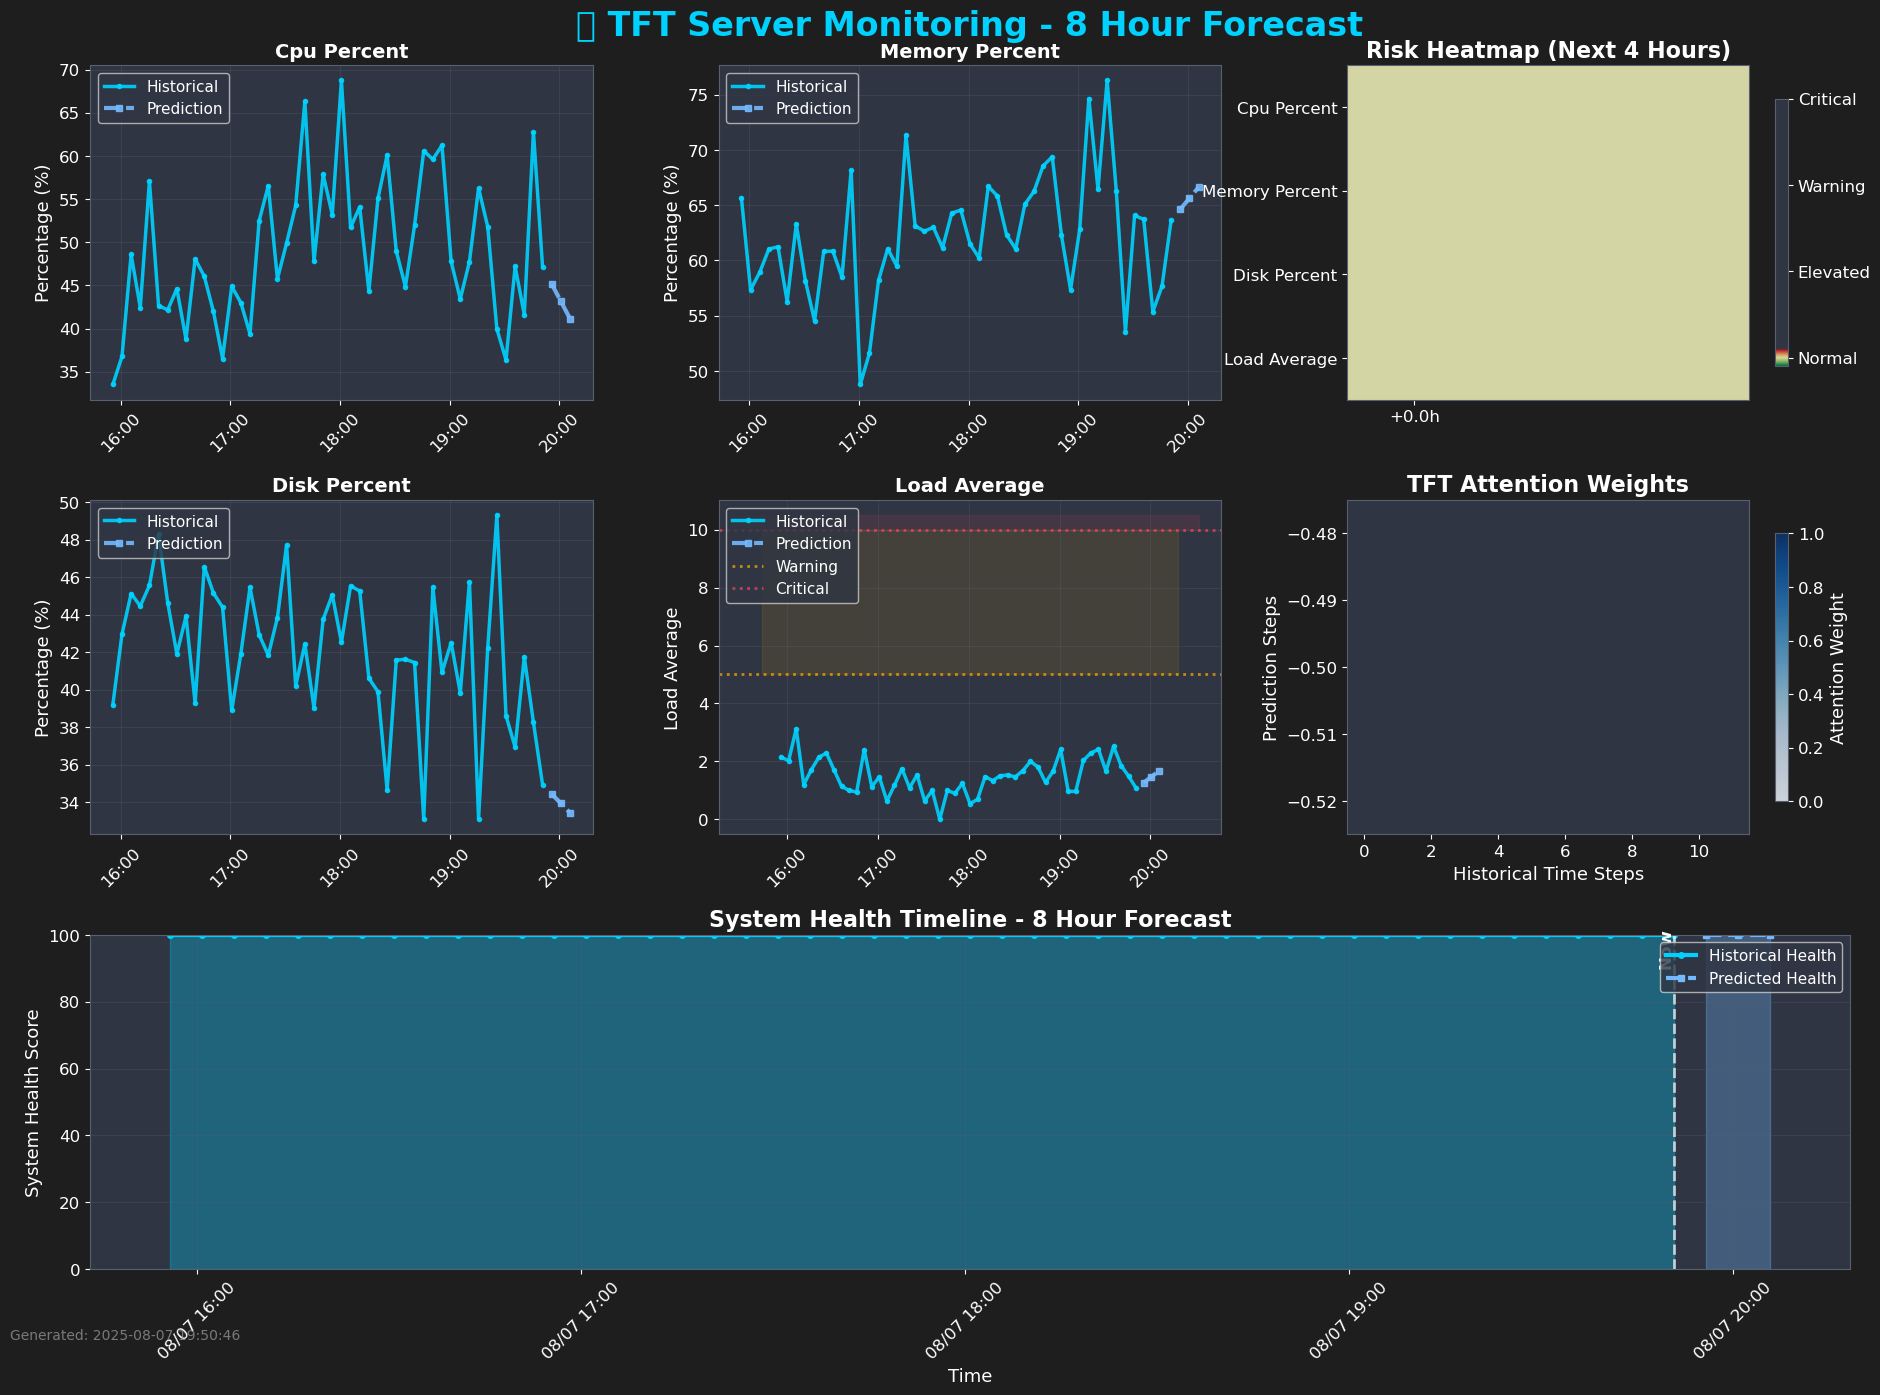

In [11]:
from enhanced_inference import predict_8_hours

# Simple prediction
results = predict_8_hours(visualize=True)

results = predict_8_hours(
    data=None,  # This will generate sample data
    visualize=True,
    save_plots="./plots/my_analysis"
)

## 🎯 Production Deployment

### Command Line Usage
```bash
# Generate larger datasets
python metrics_generator.py --hours 720  # 30 days

# Train with custom parameters
python tft_trainer.py --epochs 50 --batch-size 64

# Run inference on JSON file
python tft_inference.py --input metrics.json --output predictions.json

# Use main interface
python main.py generate --hours 720
python main.py train --epochs 50
python main.py predict --input data.json

In [ ]:
# Direct module usage
from metrics_generator import generate_dataset
from tft_trainer import train_model
from tft_inference import predict

# Generate 30 days
dataset = generate_dataset(hours=720)

# Train with custom config
model_path = train_model({'epochs': 50, 'batch_size': 64})

# Predict
results = predict(data, model_path)

In [ ]:
### **Cell 17 - Code**
```python
# 8. Final system check
print("=" * 50)
print("🎉 TFT MONITORING SYSTEM READY")
print("=" * 50)

status()

print("\n💡 Quick Reference:")
print("   generate_dataset(hours=336)  # Generate 2 weeks")
print("   train(epochs=30)             # Train model")
print("   predict(data)                # Run predictions")
print("   status()                     # Check status")

In [ ]:
# 9. Export configuration for reference
import json

config_summary = {
    'time_span_hours': CONFIG['time_span_hours'],
    'servers_count': CONFIG['servers_count'],
    'prediction_horizon': CONFIG['prediction_horizon'],
    'context_length': CONFIG['context_length'],
    'batch_size': CONFIG['batch_size'],
    'epochs': CONFIG['epochs'],
    'alert_thresholds': CONFIG['alert_thresholds']
}

print("📋 Current Configuration:")
print(json.dumps(config_summary, indent=2))

# Save for reference
with open('tft_config_summary.json', 'w') as f:
    json.dump(config_summary, f, indent=2)
print("\n💾 Configuration saved to: tft_config_summary.json")